<a href="https://colab.research.google.com/github/kiyong21c/Must_Have_Kaggle/blob/main/20220930_Bike_Sharing_Demand_df_loc_ax_patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 범주형 데이터 이진분류 경진대회
 - 다양한 범주형 데이터를 활용해 타깃값 1에 속할 확률 예측
 - 데이터 특성에 따른 맞춤형 인코딩 방법 이해
 - 문제유형 : 이진분류
 - 평가지표 : ROC AUC
 - 사용모델 : 로지스틱 회귀

 - 범주형 데이터

  > 값이 두개로만 구성된 이진 데이터 : bin_

  > 순서형 데이터 : ord_

  > 명목형 데이터 : nom_

  > 날짜 데이터 : day, month

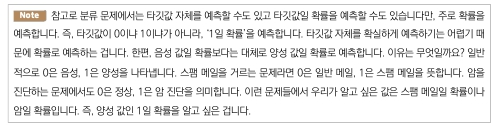

In [3]:
import numpy as np
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/cat-in-the-dat/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

In [4]:
train.shape, test.shape

((300000, 24), (200000, 23))

In [5]:
train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [6]:
train.head().T

id,0,1,2,3,4
bin_0,0,0,0,0,0
bin_1,0,1,0,1,0
bin_2,0,0,0,0,0
bin_3,T,T,F,F,F
bin_4,Y,Y,Y,Y,N
nom_0,Green,Green,Blue,Red,Red
nom_1,Triangle,Trapezoid,Trapezoid,Trapezoid,Trapezoid
nom_2,Snake,Hamster,Lion,Snake,Lion
nom_3,Finland,Russia,Russia,Canada,Canada
nom_4,Bassoon,Piano,Theremin,Oboe,Oboe


#### 피처 요약표 만들기

In [6]:
# 피처 요약표 만들기

def resumetable(df):
    print(f'데이터 형상 : {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입']) # 인덱스 : 피처명, 값 : dtypes
    summary = summary.reset_index() # 기존 인덱스인 피처명이 컬럼으로 들어감(컬럼이름은 'index')
    summary = summary.rename(columns={'index':'피처'}) # 컬럼명 rename : 'index' → '피처'
    summary['결측값 개수'] = df.isnull().sum().values # 결측값이면 True → 컬럼별 sum → 배열
    summary['고유값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    summary['세 번째 값'] = df.loc[2].values

    return summary

In [7]:
resumetable(train)

데이터 형상 : (300000, 24)


,피처,데이터 타입,결측값 개수,고유값 개수,첫 번째 값,두 번째 값,세 번째 값
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin


#### DataFrame의 데이터 접근 방법 정리
 - 1.바로인덱싱 : df[]

 > DataFrame['컬럼명']

 > DataFrame[['컬럼명1', '컬럼명2']]

 > DataFrame[행이름1:행이름2] → **슬라이싱하는경우 행으로 인식**

 > DataFrame[조건]

 - 2.df.loc[]

  > DataFrame.loc['행이름', '열이름']

  > DataFrame.loc['행이름1':'행이름2', '열이름1':'열이름2']

  > DataFrame.loc[:, '열이름'], DataFrame.loc['행이름',:]

  > DataFrame.loc['행이름'] → 열은 생략가능

  > DataFrame.loc[조건, ('컬럼명')] 


 - 3.df.iloc[] → loc[]의 이름대신 인덱스번호 사용

In [8]:
# 명목형 피처들의 고유값 확인

for col in train.columns:
    if train[col].nunique() < 200:
        print(f'{col} 고유값 : {train[col].unique()}')
    else:
        print(f'{col} 고유값의 개수가 너무 많습니다.(200개 이상)')
        

bin_0 고유값 : [0 1]
bin_1 고유값 : [0 1]
bin_2 고유값 : [0 1]
bin_3 고유값 : ['T' 'F']
bin_4 고유값 : ['Y' 'N']
nom_0 고유값 : ['Green' 'Blue' 'Red']
nom_1 고유값 : ['Triangle' 'Trapezoid' 'Polygon' 'Square' 'Star' 'Circle']
nom_2 고유값 : ['Snake' 'Hamster' 'Lion' 'Cat' 'Dog' 'Axolotl']
nom_3 고유값 : ['Finland' 'Russia' 'Canada' 'Costa Rica' 'China' 'India']
nom_4 고유값 : ['Bassoon' 'Piano' 'Theremin' 'Oboe']
nom_5 고유값의 개수가 너무 많습니다.(200개 이상)
nom_6 고유값의 개수가 너무 많습니다.(200개 이상)
nom_7 고유값의 개수가 너무 많습니다.(200개 이상)
nom_8 고유값의 개수가 너무 많습니다.(200개 이상)
nom_9 고유값의 개수가 너무 많습니다.(200개 이상)
ord_0 고유값 : [2 1 3]
ord_1 고유값 : ['Grandmaster' 'Expert' 'Novice' 'Contributor' 'Master']
ord_2 고유값 : ['Cold' 'Hot' 'Lava Hot' 'Boiling Hot' 'Freezing' 'Warm']
ord_3 고유값 : ['h' 'a' 'i' 'j' 'g' 'e' 'd' 'b' 'k' 'f' 'l' 'n' 'o' 'c' 'm']
ord_4 고유값 : ['D' 'A' 'R' 'E' 'P' 'K' 'V' 'Q' 'Z' 'L' 'F' 'T' 'U' 'S' 'Y' 'B' 'H' 'J'
 'N' 'G' 'W' 'I' 'O' 'C' 'X' 'M']
ord_5 고유값 : ['kr' 'bF' 'Jc' 'kW' 'qP' 'PZ' 'wy' 'Ed' 'qo' 'CZ' 'qX' 'su' 'dP' 'aP'
 'MV' 'oC' 'R

### 데이터 시각화

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

#### 타깃값 분포
 - 범주형 데이터 개수 확인 : sns.countplot()

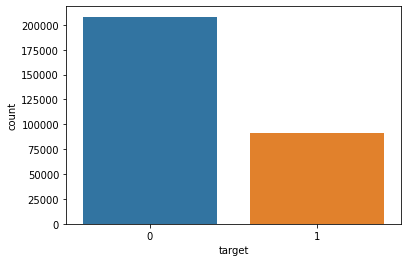

In [15]:
plt.figure(figsize=(7, 6)) # matplotlib의 figure를 사용

ax = sns.countplot(x='target', data=train) # Axes를 반환하는 axes-level function
ax.set_title('Target Distribution')

 - 각 값의 비율(전체에 대한)을 막대 상단에 표시해보자
 - ax.patches : ax축을 구성하는 그래프 도형 객체 모두를 담은 리스트

In [17]:
print(ax.patches)

[<matplotlib.patches.Rectangle object at 0x7f28077c6290>, <matplotlib.patches.Rectangle object at 0x7f2807817e50>]


In [21]:
# 첫번째 사각형(target:0)의 정보
rectangle = ax.patches[0]
print('사각형 높이:', rectangle.get_height(), '(=데이터의 개수)')
print('사각형 너비:', rectangle.get_width())
print('사각형 왼쪽 모서리 x축 좌표:', rectangle.get_x())

사각형 높이: 208236 (=데이터의 개수)
사각형 너비: 0.8
사각형 왼쪽 모서리 x축 좌표: -0.4


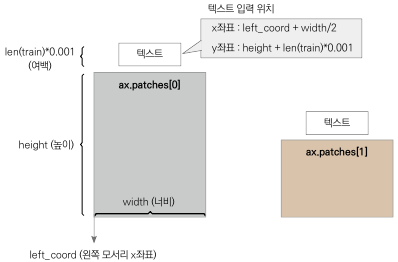

In [22]:
# 텍스트를 표시할 좌표
print('텍스트 위치의 x좌표:', rectangle.get_x() + rectangle.get_width() / 2.0)
print('텍스트 위치의 y좌표:', rectangle.get_height() + len(train) * 0.001)

텍스트 위치의 x좌표: 0.0
텍스트 위치의 y좌표: 208536.0


In [27]:
# 비율 텍스트를 표시하는 함수
def write_percent(ax, total_size):
    for patch in ax.patches:
        height = patch.get_height()
        width = patch.get_width()
        left_coord = patch.get_x()
        percent = height/total_size * 100

        ax.text(x=left_coord + width/2.0,       # x축 위치
                y=height + total_size*0.001,    # y축 위치
                s=f'{percent:1.1f}%',           # 입력 텍스트
                ha='center')                    # 정렬방식

Text(0.5, 1.0, 'Target Distribution')

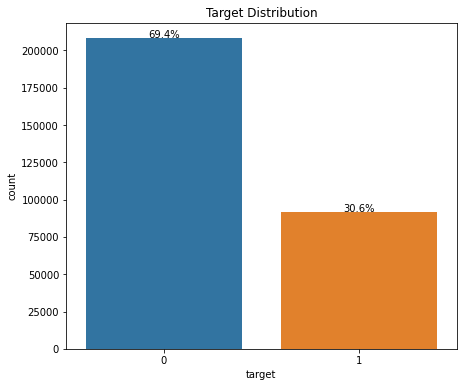

In [28]:
plt.figure(figsize=(7, 6))
ax = sns.countplot(x='target', data=train)
write_percent(ax, len(train)) # 비율 표시
ax.set_title('Target Distribution')

#### 이진 피처 분포
 - 이진 데이터(Y/N, T/F) 각 값에 타깃값이 잘 분포 되어 있는지 확인

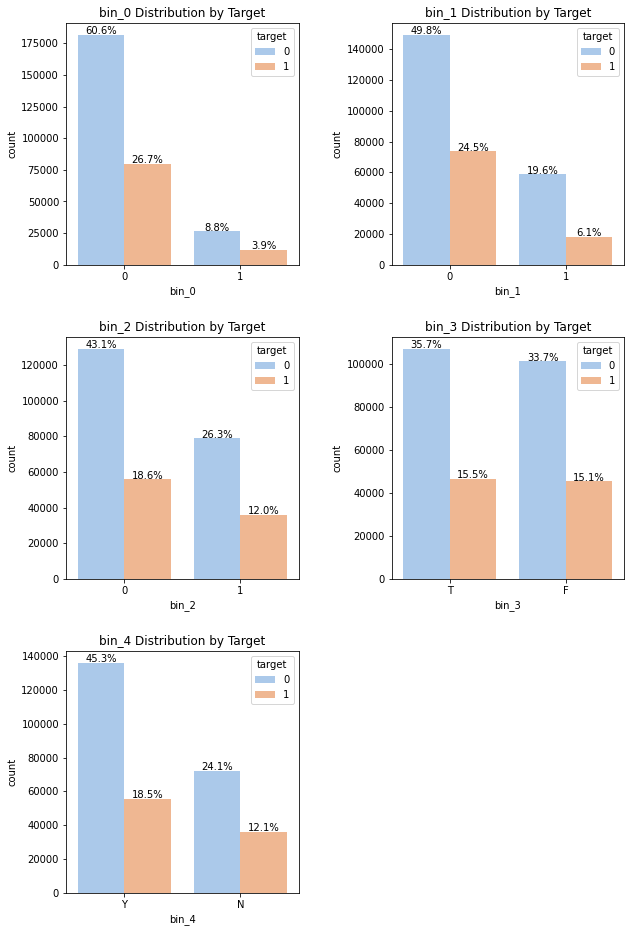

In [29]:
import matplotlib.gridspec as gridspec
# 그리드스펙 활용시 빈축이 안보이는 것이 장점

plt.figure(figsize=(10, 16))
gs = gridspec.GridSpec(3, 2) # 그리드스펙 객체 생성(3x2배치이지만 5개만 사용가능)
plt.subplots_adjust(wspace=0.4, hspace=0.3) # 서브플롯 간 좌우/상하 여백 설정

# 서브플롯 그리기
bin_features = ['bin_0','bin_1','bin_2','bin_3','bin_4'] # 피처 목록

for idx, feature in enumerate(bin_features):
    ax = plt.subplot(gs[idx]) # 함수형 방식, 그리드스펙 객체를 이용하여 축을 생성
    sns.countplot(x=feature,
                  data=train,
                  hue='target',
                  palette='pastel',
                  ax=ax)  # seaborn의 axes-level function으로 ax파라미터를 지정한다
    ax.set_title(f'{feature} Distribution by Target') # 그래프 제목
    write_percent(ax, len(train)) # 비율 표시

 - 전체 데이터에서의 0과 1의 비율과
 - 이진 데이터에서의 각 값의 0과 1의 비율이 비슷함 → 특정 타깃에 치우치지 않음



```
plt.tight_layout() : 여백 자동 조정
plt.subplots_adjust(wspace=0.4, hspace=0.3) : 여백 상하좌우 별도 조정
```



#### 명목형 피처 분포
 - nom_0 - nom_4 피처까지만 시각화

 - 1.교차분석표 생성 함수 만들기
 - 2.포인트플롯 생성 함수 만들기
 - 3.피처 분포도 및 포인트플롯 생성 함수 만들기